# Deskripsi
Deskripsi mengenai variable-variabel yang ada dalam penelitian ini akan dijelaskan dalam beberapa bagian:

1. Loading and General Description
2. Crawling indicator Description
3. 'News' Variables Description

## 0. Load Library

In [29]:
import matplotlib.pyplot as plt
import os, re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from datetime import datetime as dt
import cPickle as pickle
import re #Regex
import seaborn as sns
sns.set()
%matplotlib inline

## 1. Load and General Description

In [30]:
import MySQLdb
import pandas as pd

mysql_cn = MySQLdb.connect(host = "localhost",
                     user = "root",
                     passwd = "",
                     db = "news_yii")
df_mysql = pd.read_sql('select * from news;', con=mysql_cn,index_col='id')
dfNewsLink_mysql = pd.read_sql('select * from newslink;', con=mysql_cn, index_col='id')
mysql_cn.close()

print df_mysql.shape

(58446, 11)


In [3]:
df_mysql[df_mysql.index == 12000].values

array([[Timestamp('2016-04-28 15:06:03'), None, 5L,
        'http://economy.okezone.com/read/2016/04/28/20/1375054/dana-repatriasi-tax-amnesty-tak-harus-ditempatkan-di-bank-besar',
        'Dana Repatriasi Tax Amnesty Tak Harus Ditempatkan di Bank Besar',
        'OJK menilai pemulangan dana warga negara RI  yang diparkir di luar negeri (dana repatriasi) tidak harus ditempatkan  di bank besar.',
        '\t\t\t\t\t\t\tJAKARTA - Otoritas Jasa Keuangan (OJK) menilai pemulangan dana warga negara RI yang diparkir di luar negeri (dana repatriasi) tidak harus ditempatkan di bank besar. Bank-bank kelas BUKU I dan II juga bisa dijadikan tempat menaruh dana repatriasi.Ketua Dewan Komisioner OJK Muliaman D Hadad berpendapat, terpenting adalah perbankan Indonesia menyiapkan instrumen produk keuangan. Dia bilang, dana repatriasi bisa dimasukkan ke dalam instrumen keuangan seperti investasi di pasar modal hingga produk keuangan di perbankan.&nbsp;[Baca juga: Jokowi Diminta Bujuk Pengusaha Kembalika

In [4]:
print dfNewsLink_mysql.shape
dfNewsLink_mysql[dfNewsLink_mysql.index == 3]

(8, 3)


,descr,url,crawlClass
id,,,
3,Liputan6 - All,http://www.liputan6.com/feed/rss2,div=itemprop=description


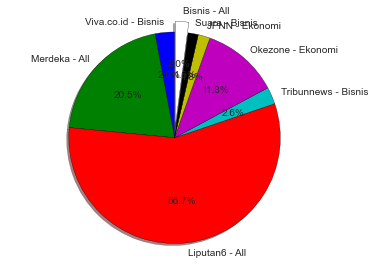

In [5]:
dataPie = df_mysql.groupby(['sumber'])['url'].count()
describ = dfNewsLink_mysql['descr'].tolist()

labels = describ
sizes = dataPie
explode = [0]*len(labels)  # only "explode" the 2nd slice (i.e. 'Hogs')

#Sorot Liputan6 yang id=3, tapi karena dari 0, jadi 2
explode[7]=.1

plt.pie(sizes, explode=explode, labels=labels,
         autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

fig = plt.figure()

In [9]:
from collections import Counter
newsByDate = df_mysql[~df_mysql.published.isnull()]
counted_dates = Counter(newsByDate.published.apply(lambda x: x.strftime("%Y-%m-%d")))
counted_series = pd.Series(counted_dates)
print 'Awal Crawl  : ',counted_series.head(1).index.values
print 'Akhir Crawl : ',counted_series.tail(1).index.values

Awal Crawl  :  ['2016-04-18']
Akhir Crawl :  ['2016-06-10']


In [21]:
import datetime as dt

def countByHour(x):
    newsByDate = x[~x.published.isnull()]
    counted_dates = Counter(newsByDate.created_at.apply(lambda x: x.strftime("%H")))
    counted_series = pd.Series(counted_dates)
    return counted_series

def countByDay(x):
    newsByDate = x[~x.published.isnull()]
    counted_dates = Counter(newsByDate.created_at.apply(lambda x: x.strftime("%Y-%m-%d")))
    counted_series = pd.Series(counted_dates)
    counted_series.index = pd.to_datetime(counted_series.index)
    return counted_series

def countByWeek(x):
    newsByDate = x[~x.published.isnull()]
    counted_dates = Counter(newsByDate.created_at.apply(lambda x: x.weekday()))
    counted_series = pd.Series(counted_dates)
    return counted_series

byHour = countByHour(df_mysql)
byDate = countByDay(df_mysql)
byWeek = countByWeek(df_mysql)

In [22]:
top3hour = byHour.sort_values(ascending=False).head(3)
top3day  = byWeek.sort_values(ascending=False).head(3)
print 'Jam paling produktif  : \n',top3hour.index.values,'\n',top3hour.values
print 'Hari paling produktif : \n',top3day.index.values,'\n',top3day.values

Jam paling produktif  : 
['15' '12' '19'] 
[4051 4009 3809]
Hari paling produktif : 
[2 1 0] 
[10903 10599  9038]


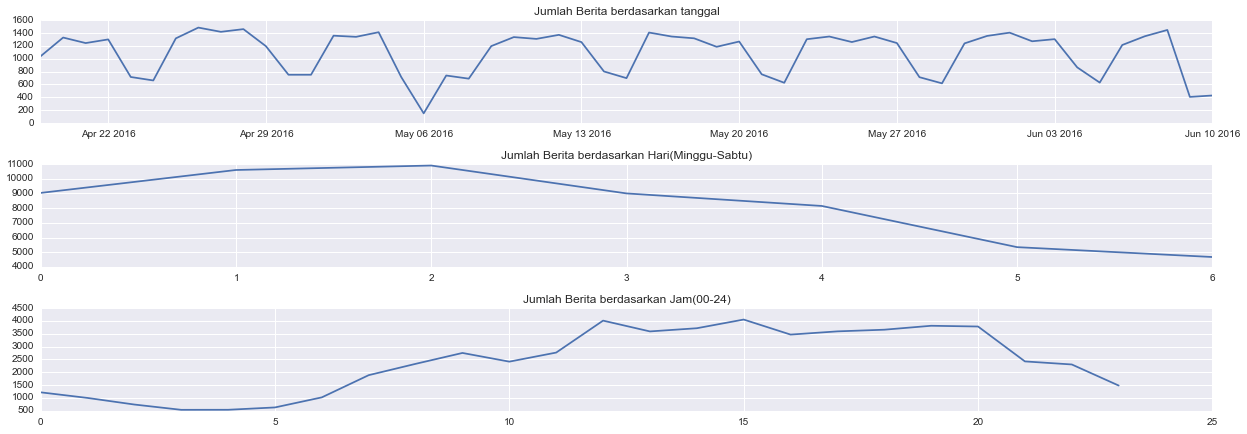

In [23]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import datetime

fig, axes = plt.subplots(nrows=3,figsize=(21,7))
axes[0].plot_date(date2num(byDate.index.to_pydatetime()),byDate.values,'-')
axes[0].set_title('Jumlah Berita berdasarkan tanggal')
axes[1].plot(byWeek.index,byWeek.values)
axes[1].set_title('Jumlah Berita berdasarkan Hari(Minggu-Sabtu)')
axes[2].plot(byHour.index,byHour.values)
axes[2].set_title('Jumlah Berita berdasarkan Jam(00-24)')

fig.subplots_adjust(hspace = 0.4)
fig.show()

### Insight

1. Total Daily
       Dari plot pertama, bisa dilihat bahwa jumlah berita yang muncul per harinya cenderung berpola naik dan turun secara teratur. Pola tersebut ada berdasarkan perbedaan hari.
   
2. Total Weekly
       Unik karena ternyata jumlah berita yang muncul menurun pada hari kerja, dan mulai naik lagi dari hari minggu, mungkin karena hari jumat dan sabtu banyak kantor-kantor yang sudah tidak aktif secara penuh lagi, sehingga sumber-sumber berita berkurang
   
3. Total Hourly
       jumlah berita mencapai puncaknya jam 12 siang, namun sudah tinggi sejak pagi. Mungkin terkait jam kerja reporter, jumlah berita langsung menurun sedari jam 12 dan jumlah berita yang paling sedikit ada di jam 19-21. Mungkin karena reporter yang mendapatkan berita pada malam hari dipublikasinya pagi esoknya, jumlah berita mulai naik pukul 22 hingga esok paginya. 

## 1. Crawling Indicator

In [25]:
DATA_ANALSISIS_crawl = df_mysql[df_mysql.crawlMem.notnull()] #Yang sudah di crawl
crawlIndicator = pd.DataFrame([DATA_ANALSISIS_crawl.crawlMem,DATA_ANALSISIS_crawl.crawlTime]).transpose()
pickle.dump(DATA_ANALSISIS_crawl, open( "v1.4\DATA_ANALSISIS_crawl-v2.p", "wb" ) )
crawlIndicator.describe()

,crawlMem,crawlTime
count,42746.000000,42746.000000
mean,3362.689187,0.992690
std,587.077727,59.015039
min,2080.000000,0.000000
25%,2808.000000,0.210900
50%,3408.000000,0.467200
75%,3520.000000,0.625200
max,7000.000000,12196.766600


## BOXPLOT Crawl

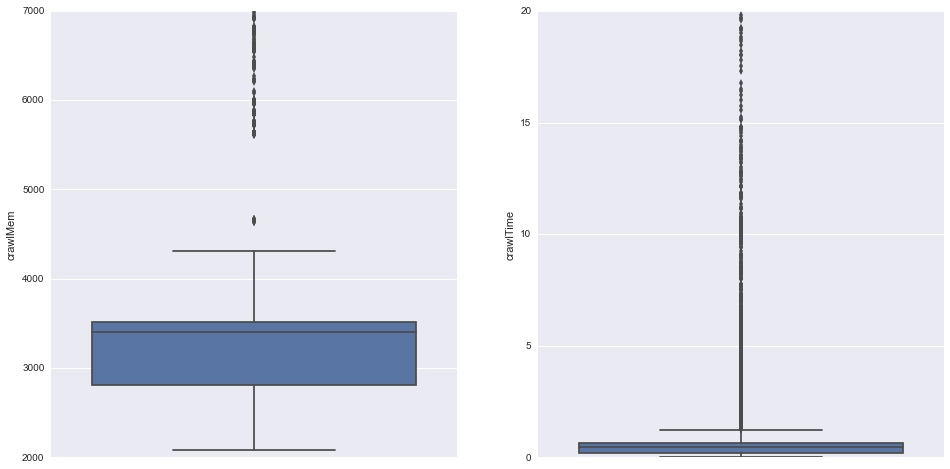

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2,figsize=(16,8))

sns.boxplot(DATA_ANALSISIS_crawl.crawlMem, orient = 'v',ax=ax[0])
sns.boxplot(DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.crawlTime < 20].crawlTime, orient = 'v', ax=ax[1])

plt.show()

In [30]:
DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.crawlTime < 6000]

,created_at,updated_at,sumber,url,judul,shortDesc,longDesc,published,crawlTime,crawlMem,flag
id,,,,,,,,,,,
28575,2016-05-14 11:00:44,None,3,http://health.liputan6.com/read/2506400/senima...,Seniman Muda Jual Puting dan Pusarnya,"\n <img src=""http://cdn1-a.production...","Liputan6.com, Jakarta Ada-ada saja kelakuan se...",2016-05-14 03:00:53,12196.7666,3408,-1


In [33]:
crawlTime_weird = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.crawlTime > DATA_ANALSISIS_crawl.crawlTime.quantile(0.75)]
print 'Paling Lama'
crawlTime_weird.sort_values(by='crawlTime', ascending=False).head(1).transpose()

Paling Lama


id,28575
created_at,2016-05-14 11:00:44
updated_at,None
sumber,3
url,http://health.liputan6.com/read/2506400/senima...
judul,Seniman Muda Jual Puting dan Pusarnya
shortDesc,"\n <img src=""http://cdn1-a.production..."
longDesc,"Liputan6.com, Jakarta Ada-ada saja kelakuan se..."
published,2016-05-14 03:00:53
crawlTime,12196.8
crawlMem,3408


In [34]:
crawlTime_weird = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.crawlMem > DATA_ANALSISIS_crawl.crawlMem.quantile(0.75)]
print 'Paling Berat'
crawlTime_weird.sort_values(by='crawlMem', ascending=False).head(1).transpose()

Paling Berat


id,47882
created_at,2016-05-31 19:01:12
updated_at,None
sumber,5
url,http://economy.okezone.com/read/2016/05/31/320...
judul,"Sate Ayam di Pinggiran Rp12 Ribu, Masuk Tesate..."
shortDesc,"Direktur Utama AP II Budi Karya Sumadi, mengis..."
longDesc,\t\t\t\t\t\t\tJAKARTA - Direktur Utama AP II B...
published,2016-05-31 11:59:55
crawlTime,19.7019
crawlMem,7000


In [35]:
DATA_ANALSISIS_crawl    = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.flag.isin([-1, 1])]
DATA_ANALSISIS_crawlPos = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.flag == 1]
DATA_ANALSISIS_crawlNeg = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.flag == -1]
crawlAnalysis = pd.DataFrame([DATA_ANALSISIS_crawlPos.crawlMem,DATA_ANALSISIS_crawlPos.crawlTime,
                              DATA_ANALSISIS_crawlNeg.crawlMem,DATA_ANALSISIS_crawlNeg.crawlTime]).transpose()
crawlAnalysis.columns = ['Memory Pos','Time Pos','Memory Neg','Time Neg']
print 'Memory Pos : ',sum(DATA_ANALSISIS_crawlPos.crawlMem), 'Byte'
print 'Memory Neg : ',sum(DATA_ANALSISIS_crawlNeg.crawlMem), 'Byte'
print 'Time Pos : ',sum(DATA_ANALSISIS_crawlPos.crawlTime), 'Detik'
print 'Time Neg : ',sum(DATA_ANALSISIS_crawlNeg.crawlTime),'Detik'
crawlAnalysis.describe()

Memory Pos :  438784.0 Byte
Memory Neg :  143302728.0 Byte
Time Pos :  43.5496 Detik
Time Neg :  42389.9669 Detik


,Memory Pos,Time Pos,Memory Neg,Time Neg
count,127.000000,127.000000,42619.000000,42619.000000
mean,3454.992126,0.342910,3362.414135,0.994626
std,823.368531,0.552273,586.223125,59.102886
min,2368.000000,0.046600,2080.000000,0.000000
25%,2520.000000,0.130900,2808.000000,0.212850
50%,3912.000000,0.147000,3408.000000,0.467800
75%,4072.000000,0.265400,3520.000000,0.625500
max,6832.000000,4.256200,7000.000000,12196.766600


## 'News' Variables

### News Filtering (Filter url from unrelevant)

In [4]:
mysql_cn = MySQLdb.connect(host = "localhost",
                     user = "root",
                     passwd = "",
                     db = "news_yii")
df_mysqlFilter = pd.read_sql('select * from news_filter;', con=mysql_cn)
mysql_cn.close()

print df_mysqlFilter.shape
df_mysqlFilter.loc[1]

(23, 3)


id                                       29
newslink_id                               2
filter         http://www.merdeka.com/sehat
Name: 1, dtype: object

In [26]:
df_mysqlFilter

,id,newslink_id,filter
0,28,2,http://www.merdeka.com/politik
1,29,2,http://www.merdeka.com/sehat
2,30,2,http://www.merdeka.com/teknologi
3,31,2,http://www.merdeka.com/gaya
4,32,2,http://www.merdeka.com/jakarta
5,44,3,http://showbiz.liputan6
6,45,3,http://regional.liputan6.com
7,46,3,http://bola.liputan6.com
8,47,3,http://video.liputan6.com
9,48,3,http://photo.liputan6.com


In [37]:
#Exclude newses that are not economy/finance topic
df_mysqlClear = pd.DataFrame(df_mysql)
# merdeka  = ['http://www.merdeka.com/politik',
#             'http://www.merdeka.com/sehat',
#             'http://www.merdeka.com/teknologi',
#             'http://www.merdeka.com/gaya',
#             'http://www.merdeka.com/jakarta']
# liputan6 = ['http://showbiz.liputan6',
#             'http://regional.liputan6.com',
#             'http://bola.liputan6.com',
#             'http://video.liputan6.com',
#             'http://photo.liputan6.com',
#             'http://otomotif.liputan6.com',
#             'http://citizen6.liputan6.com',
#             'http://health.liputan6.com',
#             'http://tekno.liputan6.com',
#             'http://lifestyle.liputan6.com',
#             'http://ramadan.liputan6.com',
#             'http://m.liputan6.com/health',
#             'http://m.liputan6.com/lifestyle',
#             'http://m.liputan6.com/bola',
#             'http://m.liputan6.com/tekno',
#             'http://m.liputan6.com/citizen6',
#             'http://m.liputan6.com/video',
#             'http://m.liputan6.com/photo']
#Undelete = Peristiwa

for fltr in df_mysqlFilter['filter'] :
    df_mysqlClear = df_mysqlClear.drop(df_mysqlClear[df_mysqlClear.url.str.startswith(fltr)].index)

df_mysqlClear.shape

(36716, 11)

In [28]:
#Take only labeled data, labeled means value of 'flag' attribute that either -1 or 1
DATA_ANALSISIS3 = df_mysqlClear[df_mysqlClear.flag.isin([-1, 1])][df_mysqlClear.crawlMem.notnull()]

DATA_JUDUL = DATA_ANALSISIS3.judul
DATA_SHORT = DATA_ANALSISIS3.shortDesc
DATA_LONG  = DATA_ANALSISIS3.longDesc
DATA_TARGET = DATA_ANALSISIS3.flag

print 'Number of Labeled Data that is Not related to business:',len(DATA_ANALSISIS3)

NameError: name 'df_mysqlClear' is not defined

In [27]:
print 'Contoh Teks yang berhasil diambil: \n'
print '"'+DATA_JUDUL[29]+'"\n'
print '"'+DATA_SHORT[29]+'"\n'
print '"'+DATA_LONG[29]+'"\n'

Contoh Teks yang berhasil diambil: 



NameError: name 'DATA_JUDUL' is not defined

In [39]:
DATA_JUDUL_words = [len(word.split()) for word in DATA_JUDUL]
DATA_SHORT_words = [len(word.split()) for word in DATA_SHORT]
DATA_LONG_words  = [len(word.split()) for word in DATA_LONG]
count_word = pd.DataFrame([DATA_JUDUL_words,DATA_SHORT_words,DATA_LONG_words]).transpose()
count_word.columns = ['Judul','Short','Long']
print 'Deskripsi mengenai jumlah kata :'
count_word.describe()

Deskripsi mengenai jumlah kata :


,Judul,Short,Long
count,28579.000000,28579.000000,28579.000000
mean,8.262885,15.775465,274.115644
std,1.629131,7.035234,138.435883
min,2.000000,1.000000,3.000000
25%,7.000000,13.000000,190.000000
50%,8.000000,15.000000,247.000000
75%,9.000000,17.000000,323.000000
max,15.000000,326.000000,2828.000000


## Little Cleaning

In [40]:
#Removing the HTML tags, similar with php's strip_tag + Removing punctuation
from HTMLParser import HTMLParser
import string

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ' '.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    striped  = s.get_data()                         #get HTML-Tags free text
    lowers   = striped.lower()                      #Lowercase all words
    nospace  = lowers.strip()                      #Remove leading and trailing white space
    return str(nospace)

#alphanum = re.sub(r'[^a-zA-Z]', ' ', lowers) #Delete all but alphanumerical
#alphanum = re.sub(r'[^a-zA-Z0-9]', ' ', lowers) #Delete all but alphanumerical and number

In [19]:
print 'Contoh Teks yang telah dihilangkan karakter Alphanumeric dan tag HTML: \n'
print '"'+strip_tags(DATA_JUDUL[29])+'"\n'
print '"'+strip_tags(DATA_SHORT[29])+'"\n'
print '"'+strip_tags(DATA_LONG[29])+'"\n'

Contoh Teks yang telah dihilangkan karakter Alphanumeric dan tag HTML: 

"kerja sama ini dibidik pengusaha ri saat di berlin"

"nilai kerja samanya hingga ratusan juta dolar."

"viva.co.id kamar dagang dan industri (kadin) indonesia menargetkan terealisasinya sejumlah penandatanganan nota kesepahaman antara perusahaan-perusaahaan eropa dan indonesia, bersamaan dengan kunjungan presiden ri joko widodo ke eropa pada 17-22 april 2016. dalam kunjungan tersebut, presiden melakukan kunjungan keempat negara yakni jerman, inggris, belgia, dan belanda bersama rombongan para pelaku usaha yang tergabung dalam kadin yang dipimpin oleh ketua umum rosan perkasa roeslani. rosan mengatakan, penandatanganan memorandum of understanding (mou) yang akan dilakukan di hadapan presiden ini merupakan langkah nyata dalam meningkatkan ekonomi indonesia. dan terus berupaya meningkatkan kerja sama dengan investor asing."ini merupakan kontribusi riil bagi perkembangan perekonomian nasional", ujar rosan dalam keter

## Vectorization

In [41]:
#Stopwords data source : https://www.illc.uva.nl/Research/Publications/Reports/MoL-2003-02.text.pdf
stopword_html = open("id.stopwords.01.01.2016.txt",'r').read()
stopwords     = stopword_html.split("\n")

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

def tableTop10(a,b,c):    
    def topKWords(docs,k):
        dummy  = docs.tolist()
        countv = CountVectorizer(stop_words=stopwords,decode_error='ignore')
        dummy  = countv.fit_transform(dummy)
        freqs = [(word, dummy.getcol(idx).sum()) for word, idx in countv.vocabulary_.items()]
        #sort from largest to smallest
        return [name for name,freq in sorted(freqs, key = lambda x: -x[1])[0:k]]
    top_word = pd.DataFrame([topKWords(a,10),
                             topKWords(b,10),
                             topKWords(c,10)]).transpose()
    return top_word

## Top 10

In [43]:
top_wordBerita = tableTop10(DATA_JUDUL,DATA_SHORT,DATA_LONG)
top_wordBerita.columns = ['Judul','Short','Long']
print '10 Kata paling tinggi Frekuensinya Pada teks Sebelum preprocessing'
top_wordBerita

10 Kata paling tinggi Frekuensinya Pada teks Sebelum preprocessing


,Judul,Short,Long
0,indonesia,com,nbsp
1,harga,align,jakarta
2,jokowi,img,2016
3,com,100,indonesia
4,jpnn,http,com
5,rumah,left,persen
6,rp,src,harga
7,polisi,hspace,pemerintah
8,ri,width,negara
9,pemerintah,jpg,baca


In [44]:
DATA_JUDULStriped = DATA_JUDUL.map(lambda x: strip_tags(x))
DATA_SHORTStriped = DATA_SHORT.map(lambda x: strip_tags(x))
DATA_LONGStriped = DATA_LONG.map(lambda x: strip_tags(x))

In [45]:
top_wordBerita = tableTop10(DATA_JUDULStriped,DATA_SHORTStriped,DATA_LONGStriped)
top_wordBerita.columns = ['Judul','Short','Long']
print '10 Kata paling tinggi Frekuensinya Pada teks setelah preprocessing'
top_wordBerita

10 Kata paling tinggi Frekuensinya Pada teks setelah preprocessing


,Judul,Short,Long
0,indonesia,indonesia,jakarta
1,harga,harga,2016
2,jokowi,pemerintah,indonesia
3,com,pt,com
4,jpnn,jakarta,persen
5,rumah,2016,harga
6,rp,persen,pemerintah
7,polisi,rumah,negara
8,ri,negara,baca
9,pemerintah,presiden,orang


### Insight

1. ##### Kata 'JPNN'
    Kata 'JPNN' adalah header setiap berita yang terdapat di rss feed jpnn.com
   
2. ##### Kata '2016'
   Kok gak ilang ?, karena dianggap bukan stopword meskipun ga mengandung informasi yang relevan

## Word Cloud

In [46]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def word3Cloud(a,b,c,title):
    fig, axes = plt.subplots(ncols=3,figsize=(15,5))

    # join tweets to a single string
    judulWord = ' '.join(a)
    shortWord = ' '.join(b)
    longWord = ' '.join(c)

    judulCloud = WordCloud(background_color='white',stopwords=stopwords,
                          width=4000,
                          height=4200
                         ).generate(judulWord)
    shortCloud = WordCloud(background_color='white',stopwords=stopwords,
                          width=4000,
                          height=4200
                         ).generate(shortWord)
    longCloud = WordCloud(background_color='white',stopwords=stopwords,
                          width=4000,
                          height=4200
                         ).generate(longWord)

    axes[0].imshow(judulCloud)
    axes[0].axis('off')
    axes[0].set_title('Judul')

    axes[1].imshow(shortCloud)
    axes[1].axis('off')
    axes[1].set_title('ShortDesc')

    axes[2].imshow(longCloud)
    axes[2].axis('off')
    axes[2].set_title('LongDesc')

    fig.suptitle(title)
    fig.savefig('img/'+title+'.png', dpi=300)
    fig.show()

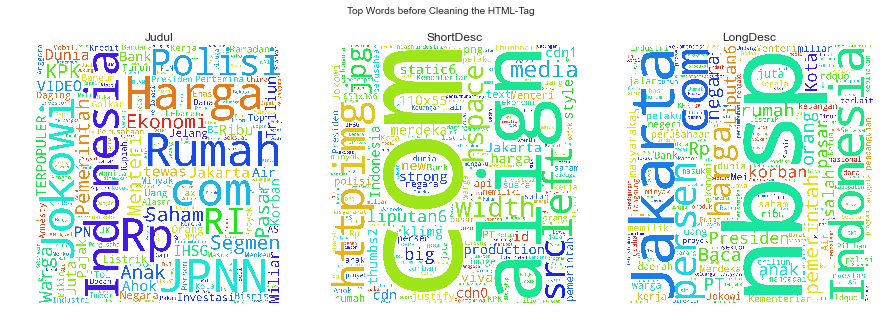

In [47]:
word3Cloud(DATA_JUDUL,
           DATA_SHORT,
           DATA_LONG,
           'Top Words before Cleaning the HTML-Tag')

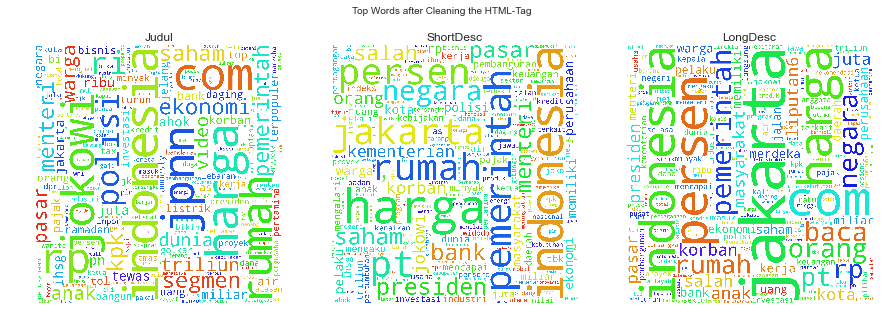

In [48]:
word3Cloud(DATA_JUDULStriped,
           DATA_SHORTStriped,
           DATA_LONGStriped,
           'Top Words after Cleaning the HTML-Tag')

In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

fs = 10
almost_black = '#262626'
sns.set()


X1 = tfidfv.fit_transform(DATA_JUDUL).toarray()
X2 = tfidfv.fit_transform(DATA_SHORT).toarray()
X3 = tfidfv.fit_transform(DATA_LONG).toarray()
y = DATA_TARGET.as_matrix()

# Instanciate a PCA object for the sake of easy visualisation
pca1 = PCA(n_components=2)
pca2 = PCA(n_components=2)
pca3 = PCA(n_components=2)

# Fit and transform x to visualise inside a 2D feature space
x1_vis = pca1.fit_transform(X1)
x2_vis = pca2.fit_transform(X2)
x3_vis = pca3.fit_transform(X3)

fig, axes = plt.subplots(ncols=3,figsize=(15,5))
# Plot the original data
palette = sns.color_palette()
axes[0].scatter(x1_vis[y == -1, 0], x1_vis[y == -1, 1], label="Class #Negatif", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
axes[0].scatter(x1_vis[y == 1, 0], x1_vis[y == 1, 1], label="Class #Positif", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
axes[0].set_title('Judul', fontsize=fs)

axes[1].scatter(x2_vis[y == -1, 0], x2_vis[y == -1, 1], label="Class #Negatif", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
axes[1].scatter(x2_vis[y == 1, 0], x2_vis[y == 1, 1], label="Class #Positif", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
axes[1].set_title('Short Description', fontsize=fs)

axes[2].scatter(x3_vis[y== -1, 0], x3_vis[y == -1, 1], label="Class #Negatif", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
axes[2].scatter(x3_vis[y == 1, 0], x3_vis[y == 1, 1], label="Class #Positif", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
axes[2].set_title('Long Description', fontsize=fs)

fig.suptitle('Gambaran 2 Dimensi 3 jenis Teks Berita (HTML and Stopwords Free)')
fig.show()
fig.savefig('img/PCA2.png', dpi=300)

## Explained Variance

In [163]:
print pca1.explained_variance_ratio_.sum() * 100
print pca2.explained_variance_ratio_.sum() * 100
print pca3.explained_variance_ratio_.sum() * 100

2.18384672943
2.15059792916
3.57709215929


In [198]:
print 'Jumlah Rata-rata kata teks Judul dan Keberagaman kata   : ',count_word.Judul.mean(),' ',X1.shape[1]
print 'Jumlah Rata-rata kata teks Short dan Keberagaman kata   : ',count_word.Short.mean(),' ',X2.shape[1]
print 'Jumlah Rata-rata kata teks Lengkap dan Keberagaman kata : ',count_word.Long.mean(),' ',X3.shape[1]

Jumlah Rata-rata kata teks Judul dan Keberagaman kata  :  7.57407407407   1512
Jumlah Rata-rata kata teks Short dan Keberagaman kata  :  14.8065843621   1831
Jumlah Rata-rata kata teks Lengkap dan Keberagaman kata :  254.201646091   11472


In [49]:
pickle.dump( DATA_JUDUL, open( "v1.4\DATA_JUDUL-v2.p", "wb" ) )
pickle.dump( DATA_SHORT, open( "v1.4\DATA_SHORT-v2.p", "wb" ) )
pickle.dump( DATA_LONG, open( "v1.4\DATA_LONG-v2.p", "wb" ) )
pickle.dump( DATA_TARGET, open( "v1.4\DATA_TARGET-v2.p", "wb" ) )

pickle.dump(DATA_JUDULStriped,open( "v1.4\DATA_JUDULStriped-v2.p", "wb" ))
pickle.dump(DATA_SHORTStriped,open( "v1.4\DATA_SHORTStriped-v2.p", "wb" ))
pickle.dump(DATA_LONGStriped,open( "v1.4\DATA_LONGStriped-v2.p", "wb" ))